# Nivelkulman tunnistaminen MediaPipe:lla

In [173]:
#!pip install mediapipe
import cv2, imutils
import mediapipe as mp

## Video youtubesta
Video haetaan youtubesta pafy kirjastolla

In [174]:
#!pip install pafy
import pafy
url="https://www.youtube.com/watch?v=QifjltKUMCk" #"https://www.youtube.com/watch?v=HdjYLZ99g-U"
video = pafy.new(url)
videoStream = video.getbestvideo(preftype="m4v")


# getting all the available streams
streams = video.allstreams
videoStream=streams[10] #Stream[]

videoStream

video:mp4@640x360

## Funktiot:
### Kulman laskeminen

In [175]:
import numpy as np

# Calculate angle
def calculateAngle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b # vector a
    bc = c - b # vector b

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180/np.pi)
    
    #Angle can't be more over 180
    if angle > 180.0:
        angle=360-angle
    
    return int(round(angle,0)) # return rounded angle (int)

#angle from XYZ
#Doesn't seem to work how it suppose to with mediaPipe
def calculateAngle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    return int(round(np.degrees(angle),0)) # return angle

### Taustan poistaminen

In [176]:
BG_COLOR = (0, 0, 0) # black
def bgSegmentation(image):
    #Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    image = np.where(condition, image, bg_image)
    
    return image

## MediaPipe


![Image of Yaktocat](https://google.github.io/mediapipe/images/mobile/pose_tracking_full_body_landmarks.png)
Landmarks
<br>

### Käynnistä sovellus
Sovelluksen komennot:<br>
1 : Taustan poisto tila<br>
2 : Kirkkauden säätö tila<br>
. : Kirkasta<br>
, : Tummenna<br>
<br>
Huom! taustan sävyn säätö toimii ainoastaan 

In [179]:
#initialize model and visualizing tool
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
selfie_segmentation = mp.solutions.selfie_segmentation.SelfieSegmentation(1)

# Choose video source
#cap = cv2.VideoCapture(0) # WebCamera
cap  = cv2.VideoCapture(videoStream.url) # Youtube video

tp=0.1
BG=False

In [ ]:

with mp_pose.Pose(
    enable_segmentation=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            break

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detections
        results = pose.process(image)

        # Background settings 
        if BG == True:
            try:
                condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1 #Uncomment for bg-segmentation
                image=bgSegmentation(image)

            except:
                pass
        else:
            image = cv2.addWeighted(image,tp,image*0,0.1,0) #uncommment this line if you want darker background


        #image=image*0 #uncomment this for black background

        #determine the points that make up the vectors for calculating the joint angle.
        # Visualize joint angle   
        try:
            landmarks = results.pose_landmarks.landmark

            # Extract X,Y,Z of landmarks - Left: hip, knee, ankle
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].z]

            # Extract X,Y,Z of landmarks - Right: hip, knee, ankle
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].z]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].z]
            right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].z]

            #Calculate location of knee in 2d dimension for visualizing
            left_knee_location = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            right_knee_location = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]

            angleL = calculateAngle(left_hip,left_knee,left_ankle)
            angleR = calculateAngle(right_hip,right_knee,right_ankle)

            #Visualize angle:

            # Left knee
            cv2.putText(image, (str(angleL)), 
                        tuple(np.multiply(left_knee_location, [670,360]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 172, 62), 1, 255)
            # Right Knee 
            cv2.putText(image, str(angleR), 
                        tuple(np.multiply(right_knee_location, [500,360]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,240,250), 1, 255)

            imshow("graph",mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS))


        except:
            pass


        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   


        #Draw detections
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        cv2.imshow('MediaPipe Pose', image)  #cv2.flip(image, 1) (Flip the image horizontally for a selfie-view display.)

        # Define key commands:
        pressedKey=cv2.waitKey(1) & 0xFF
        if pressedKey & 0xFF == ord('q'):
            break

        #Segmentation mode
        elif pressedKey == ord('1'):
            BG = True

        #Background mode
        elif pressedKey == ord('2'):
            BG = False

        #brighter bg    
        elif pressedKey == ord('.'):
            tp=tp+0.1
        #darker bg    
        elif pressedKey == ord(','):
            tp=tp-0.1
    cap.release()
    cv2.destroyAllWindows()

### Output looks like:

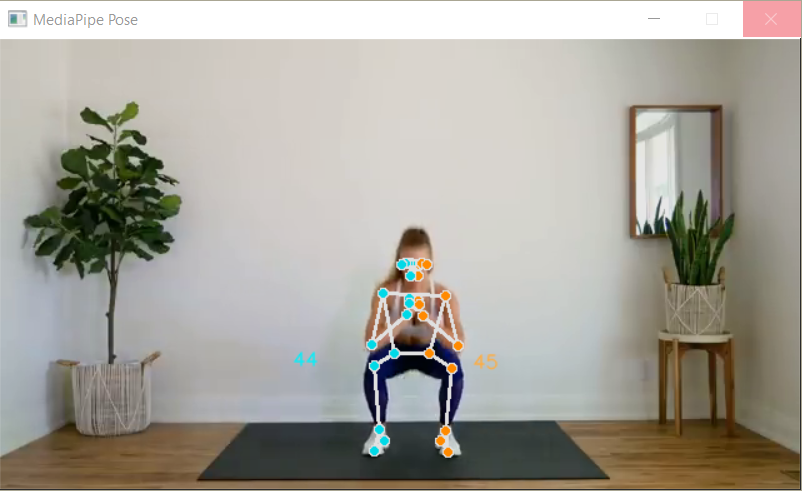
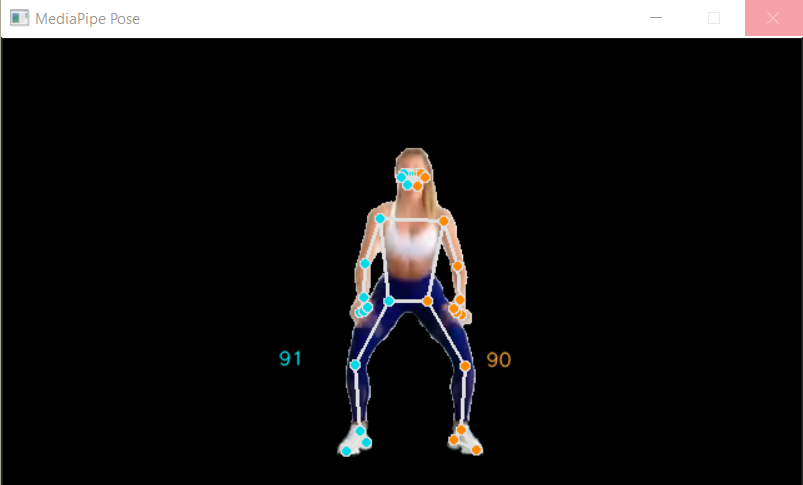
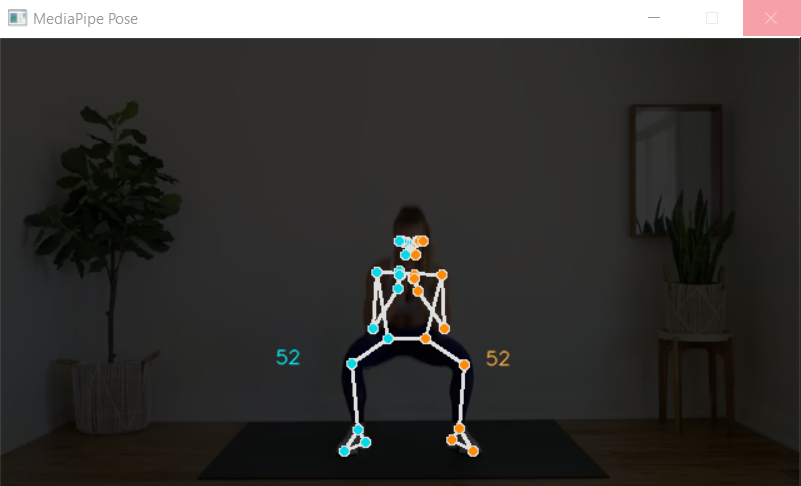
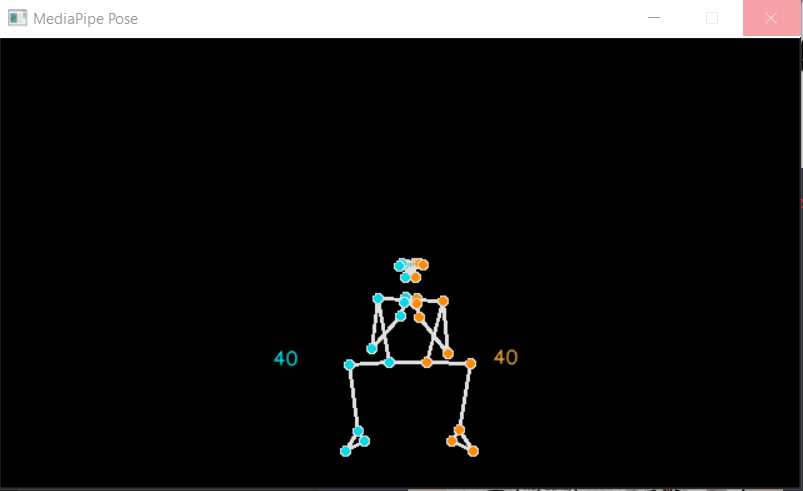

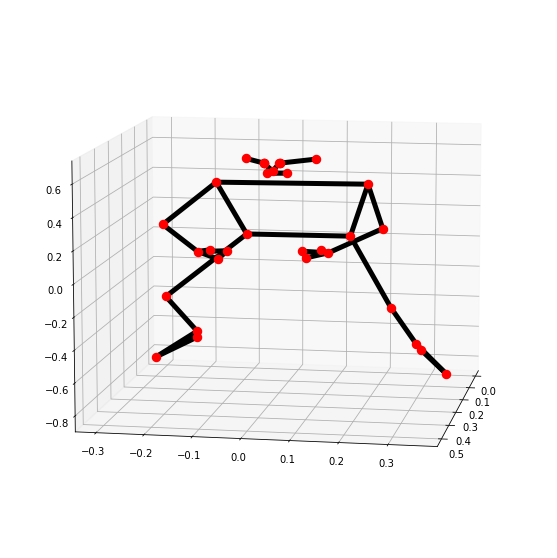

In [170]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)